In [1]:
from gvuln import *
import matplotlib.pyplot as plt
from time import time

torch.set_default_dtype(torch.float32)

# Differential Privacy

### No DP

In [20]:
compiledFile=compile2SOGA('DP_nonoise.soga')
cfg = produce_cfg(compiledFile)

output_dist = start_SOGA(cfg)

marg_nonoise = extract_marginal(output_dist, ['dataset[0]', 'avg'])

vdelta_nonoise = vdelta_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=1)
vgauss_nonoise = vgauss_bivariate_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], eps=1, idx_o=1)

gvd_nonoise = vdelta_nonoise.item()
gvg_nonoise = vgauss_nonoise.item()

gvd_nonoise, gvg_nonoise

(0.02102610468864441, 0.05263157933950424)

In [21]:
s_marg = extract_marginal(output_dist, ['dataset[0]'])
so_marg = extract_marginal(output_dist, ['dataset[0]', 'avg'])

entropy_nonoise = entropy_gaussian(s_marg.gm.mu[0], s_marg.gm.sigma[0])
cond_entropy_nonoise = cond_entropy_gaussian(so_marg.gm.mu[0], so_marg.gm.sigma[0], idx_o = [1])
mi_nonoise = mi_gaussian(marg_nonoise.gm.mu[0], marg_nonoise.gm.sigma[0], idx_o=[1])

print('Entropy of secret: ', entropy_nonoise)
print('Entropy of secret given output: ', cond_entropy_nonoise)
print('MI between secret and output: ', mi_nonoise)

Entropy of secret:  tensor(4.4147)
Entropy of secret given output:  tensor(4.3620)
MI between secret and output:  0.05268049240112305


In [22]:
compiledFile=compile2SOGA('DP_nonoise_obs.soga')
cfg = produce_cfg(compiledFile)

output_dist_obs = start_SOGA(cfg)

s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

s_mu_obs = s_marg_obs.gm.mu[0]
s_sigma_obs = s_marg_obs.gm.sigma[0]
s_mu = s_marg.gm.mu[0]
s_sigma = s_marg.gm.sigma[0]

kl_nonoise = kl_div_gaussian(s_mu_obs, s_sigma_obs, s_mu, s_sigma)

print('KL divergence between secret given output value and secret: ', kl_nonoise)


KL divergence between secret given output value and secret:  0.007680241949856281


### Gaussian Mechanism

#### Black-box Estimation

In [2]:
def gaussian_dp_model(batch_size=10, std=5.):

    dataset = distributions.Normal(40., 20.).sample([batch_size, 10])

    avg = torch.mean(dataset, dim=1, keepdim=True)

    v = distributions.Normal(0., std).sample([batch_size, 1])

    return dataset[:, 0], avg + v

def gaussian_dp_model_low_std(batch_size=10, std=5.):

    dataset = distributions.Normal(40., 2.).sample([batch_size, 10])

    avg = torch.mean(dataset, dim=1, keepdim=True)

    v = distributions.Normal(0., std).sample([batch_size, 1])

    return dataset[:, 0], avg + v

In [4]:
torch.log(torch.tensor(2.))

tensor(0.6931)

In [20]:
# black box estimation of mutual information

from sklearn.feature_selection import mutual_info_regression
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.])

mi_bbox = {}


for eps in eps_list:

    std = 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)

    mi_bbox[eps.item()] = []

    for i in range(10):
    
        s, o = gaussian_dp_model_low_std(batch_size=1_000_000, std=std)

        # Convert to numpy arrays if needed
        o = o.numpy() if hasattr(o, 'numpy') else np.array(o)
        s = s.numpy() if hasattr(s, 'numpy') else np.array(s)

        mi = mutual_info_regression(s.reshape(-1, 1), o.reshape(o.shape[0],))

        mi_bbox[eps.item()].append(mi[0])

    print(f'eps={eps.item()}: MI={np.mean(mi_bbox[eps.item()])} +/- {np.std(mi_bbox[eps.item()])}')


eps=0.10000000149011612: MI=0.00026411457584174514 +/- 0.0002872352524381053
eps=0.5: MI=0.0002615940819400642 +/- 0.0003488311525436242
eps=1.0: MI=0.0007088457000873127 +/- 0.0005317434171285101
eps=2.0: MI=0.00050632559524173 +/- 0.0005049953669404669
eps=5.0: MI=0.00018438570506127406 +/- 0.0003422971114441122
eps=10.0: MI=0.0002849321169422936 +/- 0.0005189346180720202
eps=50.0: MI=0.017840359103467752 +/- 0.0007354015325338707
eps=60.0: MI=0.026802331982624848 +/- 0.0008566715349866342
eps=70.0: MI=0.035127834002958026 +/- 0.0008757747911520203
eps=80.0: MI=0.04013567248266155 +/- 0.000673581956662495
eps=90.0: MI=0.044380533600040906 +/- 0.0007559691482044528
eps=100.0: MI=0.047337172617173094 +/- 0.0007738592147287062


In [21]:
# black box estimation of mutual information

from sklearn.feature_selection import mutual_info_regression
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.])

mi_bbox = {}


for eps in eps_list:

    std = 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)

    mi_bbox[eps.item()] = []

    for i in range(10):
    
        s, o = gaussian_dp_model(batch_size=1_000_000, std=std)

        # Convert to numpy arrays if needed
        o = o.numpy() if hasattr(o, 'numpy') else np.array(o)
        s = s.numpy() if hasattr(s, 'numpy') else np.array(s)

        mi = mutual_info_regression(s.reshape(-1, 1), o.reshape(o.shape[0],))

        mi_bbox[eps.item()].append(mi[0])

    print(f'eps={eps.item()}: MI={np.mean(mi_bbox[eps.item()])} +/- {np.std(mi_bbox[eps.item()])}')


eps=0.10000000149011612: MI=0.00028939662512206255 +/- 0.0004288530067662328
eps=0.5: MI=0.000548043312351254 +/- 0.0004647738929004353
eps=1.0: MI=0.00028750988466743623 +/- 0.0003517853248702159
eps=2.0: MI=0.0005238183952879893 +/- 0.0004929623400627369
eps=5.0: MI=0.0004442983390703148 +/- 0.0005432992983022256
eps=10.0: MI=0.004162455795477004 +/- 0.000643215925806041
eps=50.0: MI=0.051634542918137606 +/- 0.0005394609020811743
eps=60.0: MI=0.05219335809157784 +/- 0.000885778621600628
eps=70.0: MI=0.05272248466464591 +/- 0.0008982183257782897
eps=80.0: MI=0.05254428993007778 +/- 0.0008408311756706076
eps=90.0: MI=0.052636241348205104 +/- 0.0006584088614244909
eps=100.0: MI=0.05256129923395951 +/- 0.0007696555280497951


In [29]:
# old method: this works for the gaussian but is in general unsound

from sklearn.neighbors import KNeighborsRegressor
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.])

gvuln_bbox = {}


for eps in eps_list:

    std = 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)

    gvuln_bbox[eps.item()] = []

    for i in range(10):
    
        s_train, o_train = gaussian_dp_model(batch_size=1_000_000, std=std)
        s_test, o_test = gaussian_dp_model(batch_size=100_000, std=std)

        # Convert to numpy arrays if needed
        o_train_np = o_train.numpy() if hasattr(o_train, 'numpy') else np.array(o_train)
        s_train_np = s_train.numpy() if hasattr(s_train, 'numpy') else np.array(s_train)
        o_test_np = o_test.numpy() if hasattr(o_test, 'numpy') else np.array(o_test)
        s_test_np = s_test.numpy() if hasattr(s_test, 'numpy') else np.array(s_test)

        # Fit KNN regressor
        knn = KNeighborsRegressor(n_neighbors=100)
        knn.fit(o_train_np.reshape(-1, 1), s_train_np)  # reshape if o_train is 1D

        # Predict for test set
        s_pred = knn.predict(o_test_np.reshape(-1, 1))

        # Custom loss function (example: mean absolute error)
        def custom_loss(y_true, y_pred):
            return np.mean(np.exp(-0.5 * (y_true - y_pred) ** 2))

        loss = custom_loss(s_test_np, s_pred)

        gvuln_bbox[eps.item()].append(loss)

for key, list in gvuln_bbox.items():
    
    gvuln_bbox[key] = torch.tensor(list)

    print('Eps: ', key, 'Mean:', torch.mean(gvuln_bbox[key]), 'Std:', torch.std(gvuln_bbox[key]))


Eps:  0.10000000149011612 Mean: tensor(0.0499) Std: tensor(0.0004)
Eps:  0.5 Mean: tensor(0.0498) Std: tensor(0.0006)
Eps:  1.0 Mean: tensor(0.0494) Std: tensor(0.0010)
Eps:  2.0 Mean: tensor(0.0496) Std: tensor(0.0007)
Eps:  5.0 Mean: tensor(0.0499) Std: tensor(0.0004)
Eps:  10.0 Mean: tensor(0.0500) Std: tensor(0.0006)
Eps:  50.0 Mean: tensor(0.0526) Std: tensor(0.0005)
Eps:  60.0 Mean: tensor(0.0520) Std: tensor(0.0006)
Eps:  70.0 Mean: tensor(0.0525) Std: tensor(0.0007)
Eps:  80.0 Mean: tensor(0.0524) Std: tensor(0.0006)
Eps:  90.0 Mean: tensor(0.0526) Std: tensor(0.0004)
Eps:  100.0 Mean: tensor(0.0526) Std: tensor(0.0007)


#### SOGA estimation

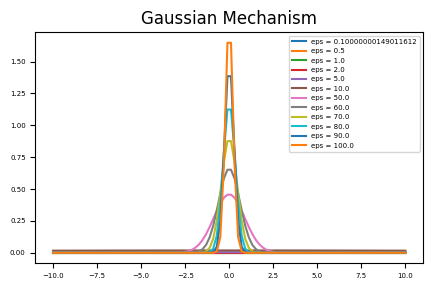

In [23]:
Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.])

plt.figure(figsize=(5, 3))

for eps in eps_list:

    pars = {'std': 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=True)    

    program = 'noise = gm([1.], [0.], [_std]);'
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-10, 10, 100).reshape(100, 1)
    y = output_dist.gm.pdf(x).detach().numpy()
    plt.plot(x, y, label='eps = {}'.format(eps))

plt.title('Gaussian Mechanism')
plt.legend(fontsize=5)
plt.tick_params(axis='x', labelsize=5)
plt.tick_params(axis='y', labelsize=5)


In [24]:
Delta = 150/10
delta = 1/100
eps_list = [0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.]

gvd_gauss = {}   # g-vulnerability for delta gain
gvg_gauss = {}   # g-vulnerability for Gaussian gain
entropy_gauss = {}       # entropy of the secret variable
cond_entropy_gauss = {}  # conditional entropy of secret given output
mi_gauss = {}            # mutual information between secret and output
kl_gauss = {}        # KL divergence between secret given output value and secret 

for eps in eps_list:

    print('Eps: ', eps)

    eps = torch.tensor(eps)

    compiledFile=compile2SOGA('DP_Gauss_low_std.soga')
    cfg = produce_cfg(compiledFile)


    pars = {'std': 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    print('std:', 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_gauss = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    s_marg_gauss = extract_marginal(output_dist, ['dataset[0]'])

    entropy_gauss['{}'.format(eps)] = entropy_gaussian(s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    cond_entropy_gauss['{}'.format(eps)] = cond_entropy_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    mi_gauss['{}'.format(eps)] = mi_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    gvd_gauss['{}'.format(eps)] =  vdelta_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=1).item()
    gvg_gauss['{}'.format(eps)] = vgauss_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], eps=1, idx_o=1).item()

    compiledFile=compile2SOGA('DP_Gauss_obs.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    s_marg_gauss_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

    kl_gauss['{}'.format(eps)] = kl_div_gaussian(s_marg_gauss_obs.gm.mu[0], s_marg_gauss_obs.gm.sigma[0], s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])


Eps:  0.1
std: tensor(217274.1094)
Eps:  0.5
std: tensor(8690.9648)
Eps:  1.0
std: tensor(2172.7412)
Eps:  2.0
std: tensor(543.1853)
Eps:  5.0
std: tensor(86.9096)
Eps:  10.0
std: tensor(21.7274)
Eps:  50.0
std: tensor(0.8691)
Eps:  60.0
std: tensor(0.6035)
Eps:  70.0
std: tensor(0.4434)
Eps:  80.0
std: tensor(0.3395)
Eps:  90.0
std: tensor(0.2682)
Eps:  100.0
std: tensor(0.2173)


In [25]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvd_gauss[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvg_gauss[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), cond_entropy_gauss[key]))

print('\n Mutual Information   ')
for key in mi_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), mi_gauss[key]))

print('\n KL Divergence   ')
for key in kl_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), kl_gauss[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.1, exact=0.199471
	 Eps = 0.5, exact=0.199471
	 Eps = 1.0, exact=0.199471
	 Eps = 2.0, exact=0.199471
	 Eps = 5.0, exact=0.199472
	 Eps = 10.0, exact=0.199480
	 Eps = 50.0, exact=0.203017
	 Eps = 60.0, exact=0.204905
	 Eps = 70.0, exact=0.206514
	 Eps = 80.0, exact=0.207696
	 Eps = 90.0, exact=0.208502
	 Eps = 100.0, exact=0.209039

 G-Vulnerability (Gauss Gain)
	 Eps = 0.1, exact=0.447214
	 Eps = 0.5, exact=0.447214
	 Eps = 1.0, exact=0.447214
	 Eps = 2.0, exact=0.447214
	 Eps = 5.0, exact=0.447215
	 Eps = 10.0, exact=0.447229
	 Eps = 50.0, exact=0.453539
	 Eps = 60.0, exact=0.456881
	 Eps = 70.0, exact=0.459712
	 Eps = 80.0, exact=0.461783
	 Eps = 90.0, exact=0.463192
	 Eps = 100.0, exact=0.464127

 Conditional Entropy   
	 Eps = 0.1, exact=2.112086
	 Eps = 0.5, exact=2.112086
	 Eps = 1.0, exact=2.112086
	 Eps = 2.0, exact=2.112085
	 Eps = 5.0, exact=2.112083
	 Eps = 10.0, exact=2.112043
	 Eps = 50.0, exact=2.094468
	 Eps = 60.0, exact=2.085207


In [26]:
Delta = 150/10
delta = 1/100
eps_list = [0.1, 0.5, 1., 2., 5., 10., 50., 60., 70., 80., 90., 100.]

gvd_gauss = {}   # g-vulnerability for delta gain
gvg_gauss = {}   # g-vulnerability for Gaussian gain
entropy_gauss = {}       # entropy of the secret variable
cond_entropy_gauss = {}  # conditional entropy of secret given output
mi_gauss = {}            # mutual information between secret and output
kl_gauss = {}        # KL divergence between secret given output value and secret 

for eps in eps_list:

    print('Eps: ', eps)

    eps = torch.tensor(eps)

    compiledFile=compile2SOGA('DP_Gauss.soga')
    cfg = produce_cfg(compiledFile)


    pars = {'std': 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2)}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    print('std:', 2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))

    output_dist = start_SOGA(cfg, params_dict=params_dict)

    marg_gauss = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    s_marg_gauss = extract_marginal(output_dist, ['dataset[0]'])

    entropy_gauss['{}'.format(eps)] = entropy_gaussian(s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])
    cond_entropy_gauss['{}'.format(eps)] = cond_entropy_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    mi_gauss['{}'.format(eps)] = mi_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=[1])
    gvd_gauss['{}'.format(eps)] =  vdelta_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], idx_o=1).item()
    gvg_gauss['{}'.format(eps)] = vgauss_bivariate_gaussian(marg_gauss.gm.mu[0], marg_gauss.gm.sigma[0], eps=1, idx_o=1).item()

    compiledFile=compile2SOGA('DP_Gauss_obs.soga')
    cfg = produce_cfg(compiledFile)

    pars = {'std': torch.sqrt(2*Delta**2*torch.log(torch.tensor(1.25/delta))/(eps**2))}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value.item(), requires_grad=False)    

    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    s_marg_gauss_obs = extract_marginal(output_dist_obs, ['dataset[0]'])

    kl_gauss['{}'.format(eps)] = kl_div_gaussian(s_marg_gauss_obs.gm.mu[0], s_marg_gauss_obs.gm.sigma[0], s_marg_gauss.gm.mu[0], s_marg_gauss.gm.sigma[0])


Eps:  0.1
std: tensor(217274.1094)
Eps:  0.5
std: tensor(8690.9648)
Eps:  1.0
std: tensor(2172.7412)
Eps:  2.0
std: tensor(543.1853)
Eps:  5.0
std: tensor(86.9096)
Eps:  10.0
std: tensor(21.7274)
Eps:  50.0
std: tensor(0.8691)
Eps:  60.0
std: tensor(0.6035)
Eps:  70.0
std: tensor(0.4434)
Eps:  80.0
std: tensor(0.3395)
Eps:  90.0
std: tensor(0.2682)
Eps:  100.0
std: tensor(0.2173)


In [27]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvd_gauss[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), gvg_gauss[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), cond_entropy_gauss[key]))

print('\n Mutual Information   ')
for key in mi_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), mi_gauss[key]))

print('\n KL Divergence   ')
for key in kl_gauss.keys():
    print('\t Eps = {:.1f}, exact={:.6f}'.format(float(key), kl_gauss[key]))

G-Vulnerability (Delta Gain)
	 Eps = 0.1, exact=0.019947
	 Eps = 0.5, exact=0.019947
	 Eps = 1.0, exact=0.019947
	 Eps = 2.0, exact=0.019947
	 Eps = 5.0, exact=0.019952
	 Eps = 10.0, exact=0.020025
	 Eps = 50.0, exact=0.021004
	 Eps = 60.0, exact=0.021016
	 Eps = 70.0, exact=0.021020
	 Eps = 80.0, exact=0.021023
	 Eps = 90.0, exact=0.021024
	 Eps = 100.0, exact=0.021025

 G-Vulnerability (Gauss Gain)
	 Eps = 0.1, exact=0.049938
	 Eps = 0.5, exact=0.049938
	 Eps = 1.0, exact=0.049938
	 Eps = 2.0, exact=0.049938
	 Eps = 5.0, exact=0.049951
	 Eps = 10.0, exact=0.050133
	 Eps = 50.0, exact=0.052578
	 Eps = 60.0, exact=0.052605
	 Eps = 70.0, exact=0.052617
	 Eps = 80.0, exact=0.052623
	 Eps = 90.0, exact=0.052626
	 Eps = 100.0, exact=0.052628

 Conditional Entropy   
	 Eps = 0.1, exact=4.414671
	 Eps = 0.5, exact=4.414670
	 Eps = 1.0, exact=4.414670
	 Eps = 2.0, exact=4.414664
	 Eps = 5.0, exact=4.414407
	 Eps = 10.0, exact=4.410749
	 Eps = 50.0, exact=4.363019
	 Eps = 60.0, exact=4.362492


### Laplacian Mechanism

#### Black-Box Estimation

In [39]:
def laplacian_dp_model(batch_size=10, b=1.):

    dataset = distributions.Normal(40., 20.).sample([batch_size, 10])

    avg = torch.mean(dataset, dim=1, keepdim=True)

    v = distributions.Laplace(0., b).sample([batch_size, 1])

    return dataset[:, 0], avg + v

In [50]:
import numpy as np
from scipy.optimize import fsolve
from sklearn.neighbors import KNeighborsRegressor


def equation(x, s_train):
    return np.sum((x - s_train) * np.exp(-0.5 * (x - s_train)**2))

def custom_loss(y_true, y_pred):
    return np.mean(np.exp(-0.5 * (y_true - y_pred) ** 2))


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.10, 0.5, 1., 2., 5., 10.])

gvuln_bbox = {}


for eps in eps_list:

    gvuln_bbox[eps.item()] = []

    b = eps

    for i in range(10):

        s_train, o_train = laplacian_dp_model(batch_size= 1_000_000, b=b)
        s_test, o_test = laplacian_dp_model(batch_size= 100_000, b=b)

        o_train_np = o_train.numpy() if hasattr(o_train, 'numpy') else np.array(o_train)
        s_train_np = s_train.numpy() if hasattr(s_train, 'numpy') else np.array(s_train)
        o_test_np = o_test.numpy() if hasattr(o_test, 'numpy') else np.array(o_test)
        s_test_np = s_test.numpy() if hasattr(s_test, 'numpy') else np.array(s_test)

        # Computing weights as solution of fixed point equation


        # Fit KNN as usual
        knn = KNeighborsRegressor(n_neighbors=100, weights='uniform')
        knn.fit(o_train_np.reshape(-1, 1), s_train_np)

        # For each test point, get neighbors and apply custom weights
        distances, indices = knn.kneighbors(o_test_np.reshape(-1, 1))
        s_neighbors = s_train_np[indices]  # shape: (n_test, n_neighbors)

        # Applying custom weights for estimation
        s_pred = []
        for i in range(s_neighbors.shape[0]):   # cycles over test points
            s_i = s_neighbors[i]  # neighbours of the i-th test point
            # Initial guess for x
            x0 = np.mean(s_i)
            # Solve for x
            solution = fsolve(equation, x0, args=(s_i))
            fix = solution[0]
            # compute weights
            #w = np.exp(-0.5 * (s_i - fix)**2)
            #w = w / np.sum(w)
            #pred = np.sum(w * s_i)
            s_pred.append(fix)
    
        loss = custom_loss(s_test_np, s_pred)

        gvuln_bbox[eps.item()].append(loss)

for key, list in gvuln_bbox.items():
    
    gvuln_bbox[key] = torch.tensor(list)

    print('Eps: ', key, 'Mean:', torch.mean(gvuln_bbox[key]), 'Std:', torch.std(gvuln_bbox[key]))

    

Eps:  0.10000000149011612 Mean: tensor(0.0505, dtype=torch.float64) Std: tensor(0.0007, dtype=torch.float64)
Eps:  0.5 Mean: tensor(0.0503, dtype=torch.float64) Std: tensor(0.0004, dtype=torch.float64)
Eps:  1.0 Mean: tensor(0.0505, dtype=torch.float64) Std: tensor(0.0008, dtype=torch.float64)
Eps:  2.0 Mean: tensor(0.0498, dtype=torch.float64) Std: tensor(0.0005, dtype=torch.float64)
Eps:  5.0 Mean: tensor(0.0489, dtype=torch.float64) Std: tensor(0.0007, dtype=torch.float64)
Eps:  10.0 Mean: tensor(0.0485, dtype=torch.float64) Std: tensor(0.0005, dtype=torch.float64)


In [24]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np


Delta = 150/10
delta = 1/100
eps_list = torch.tensor([0.1, 0.5, 1., 2., 5., 10.])

gvuln_bbox = {}


for eps in eps_list:

    b = Delta/eps

    gvuln_bbox[eps.item()] = []

    for i in range(20):
    
        s_train, o_train = original_model(batch_size=1_000_000, b=b)
        s_test, o_test = original_model(batch_size=100_000, b=b)

        # Convert to numpy arrays if needed
        o_train_np = o_train.numpy() if hasattr(o_train, 'numpy') else np.array(o_train)
        s_train_np = s_train.numpy() if hasattr(s_train, 'numpy') else np.array(s_train)
        o_test_np = o_test.numpy() if hasattr(o_test, 'numpy') else np.array(o_test)
        s_test_np = s_test.numpy() if hasattr(s_test, 'numpy') else np.array(s_test)

        # Fit KNN regressor
        knn = KNeighborsRegressor(n_neighbors=10)
        knn.fit(o_train_np.reshape(-1, 1), s_train_np)  # reshape if o_train is 1D

        # Predict for test set
        s_pred = knn.predict(o_test_np.reshape(-1, 1))

        # Custom loss function (example: mean absolute error)
        def custom_loss(y_true, y_pred):
            return np.mean(np.exp(-0.5 * (y_true - y_pred) ** 2))

        loss = custom_loss(s_test_np, s_pred)

        gvuln_bbox[eps.item()].append(loss)

for key, list in gvuln_bbox.items():
    
    gvuln_bbox[key] = torch.tensor(list)

    print('Eps: ', key, 'Mean:', torch.mean(gvuln_bbox[key]), 'Std:', torch.std(gvuln_bbox[key]))


Eps:  0.10000000149011612 Mean: tensor(0.0475) Std: tensor(0.0006)
Eps:  0.5 Mean: tensor(0.0477) Std: tensor(0.0006)
Eps:  1.0 Mean: tensor(0.0481) Std: tensor(0.0006)
Eps:  2.0 Mean: tensor(0.0483) Std: tensor(0.0005)
Eps:  5.0 Mean: tensor(0.0494) Std: tensor(0.0005)
Eps:  10.0 Mean: tensor(0.0499) Std: tensor(0.0007)


#### SOGA Estimation

<Figure size 500x300 with 0 Axes>

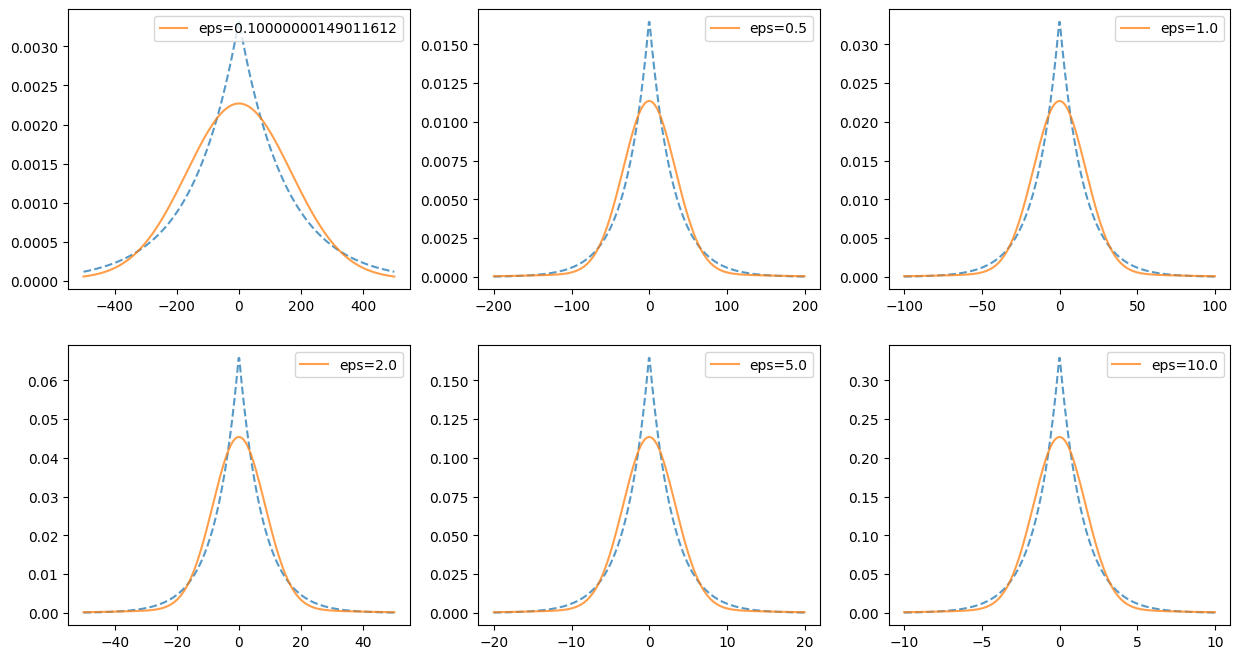

In [17]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(5, 3))

Delta = 150/10

eps_list = [0.1, 0.5, 1., 2., 5., 10.]
M_list = [500, 200, 100, 50, 20, 10]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, eps in enumerate(eps_list):

    eps = torch.tensor(eps)

    b = Delta/eps
    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    program = 'v = gm([_p1, _p2], [_mean1, _mean2], [_sigma1, _sigma2]);'

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)

    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    dist = start_SOGA(cfg, params_dict=params_dict)

    x = torch.linspace(-M_list[i], M_list[i], 500).reshape(500, 1)
    y = dist.gm.pdf(x).detach().numpy()
    y_lap = Laplace(0., b).log_prob(x).exp().detach().numpy()


    ax = axes.flat[i]
    ax.plot(x, y_lap, '--', alpha=0.75)
    ax.plot(x, y, label='eps={}'.format(eps.item()), alpha=0.75)
    ax.legend()

#plt.legend(fontsize=5)
#plt.tick_params(axis='x', labelsize=5)
#plt.tick_params(axis='y', labelsize=5)
#plt.show()


In [18]:
Delta = 150./10.
eps_list = torch.tensor([1.])#0.1, 0.5, 1., 2., 5., 10.])

gvd_lap_lb = {}
gvd_lap_ub = {}
gvg_lap_lb = {}
gvg_lap_ub = {}

gvd_lap = {}
gvg_lap = {}

cond_entropy_lap_lb = {}
cond_entropy_lap_ub = {}
cond_entropy_lap = {}

mi_lap_lb = {}
mi_lap_ub = {}
mi_lap = {}

kl_lap_lb = {}
kl_lap_ub = {}
kl_lap = {}


sampling_time = 0.
bounds_time = 0.

for eps in eps_list:

    n_samples = 100_000

    print('n Eps: ', eps)

    # Approximating the Laplace
    b = Delta/eps

    print('b:', b)

    pi, mu1, mu2, sigma1, sigma2, _ = fit_laplace(torch.tensor(0.), b)

    
    pars = {'p1': pi,
            'p2': 1-pi,
            'mean1': mu1,
            'mean2': mu2,
            'sigma1': sigma1,
            'sigma2': sigma2}
    params_dict = {}
    for key, value in pars.items():
        params_dict[key] = torch.tensor(value, requires_grad=True)    

    # Computing SOGA outputs
    compiledFile=compile2SOGA('DP_Laplace.soga')
    cfg = produce_cfg(compiledFile)
    output_dist = start_SOGA(cfg, params_dict=params_dict)

    compiledFile=compile2SOGA('DP_Laplace_obs.soga')
    cfg = produce_cfg(compiledFile)
    output_dist_obs = start_SOGA(cfg, params_dict=params_dict)

    # Extracting marginals
    marg_lap = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    marg_lap = aggregate_mixture(marg_lap)
    s_marg = extract_marginal(output_dist, ['dataset[0]'])
    s_marg = aggregate_mixture(s_marg)
    s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # Computes bounds
    start = time()
    gvd_lap_lb['{}'.format(eps)] = vdelta_lower_bound(marg_lap, idx_o=1)
    gvd_lap_ub['{}'.format(eps)] = vdelta_upper_bound(marg_lap, idx_o=1)
    gvg_lap_lb['{}'.format(eps)] = vgauss_lower_bound(marg_lap, 1., idx_o=1)
    gvg_lap_ub['{}'.format(eps)] = vgauss_upper_bound(marg_lap, 1., idx_o=1)

    cond_entropy_lap_lb['{}'.format(eps)] = cond_entropy_lb(marg_lap, idx_o=[1])
    cond_entropy_lap_ub['{}'.format(eps)] = cond_entropy_ub(marg_lap, idx_o=[1])
    
    mi_lap_lb['{}'.format(eps)] = mi_lb(marg_lap, idx_o=[1])
    mi_lap_ub['{}'.format(eps)] = mi_ub(marg_lap, idx_o=[1])

    kl_lap_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_lap_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    end = time()
    bounds_time += end - start

    # Computes exact values via MCMC
    start = time()
    gvd_lap['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='delta', secret_var='dataset[0]', output_var='avg')
    gvg_lap['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='gauss', secret_var='dataset[0]', output_var='avg')
    
    cond_entropy_lap['{}'.format(eps)] = sample_cond_entropy(marg_lap, idx_o=[1], n_samples=n_samples)
    
    mi_lap['{}'.format(eps)] = sample_mi(marg_lap, idx_o=[1], n_samples=n_samples)
    
    kl_lap['{}'.format(eps)] = sample_kl(s_marg_obs, s_marg, n_samples)
    end = time()
    sampling_time += end - start

print('Bounds time: ', bounds_time)
print('Sampling time: ', sampling_time)

    
    

n Eps:  tensor(1.)
b: tensor(15.)
Bounds time:  0.022603273391723633
Sampling time:  3.032960891723633
Bounds time:  0.022603273391723633
Sampling time:  3.032960891723633


In [19]:
output_dist.gm.mean()

tensor([40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,  0., 40.],
       grad_fn=<SumBackward1>)

In [20]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_lap_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvd_lap_lb[key], gvd_lap[key], gvg_lap_ub[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvg_lap_lb[key], gvg_lap[key], gvg_lap_ub[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_entropy_lap_lb[key], cond_entropy_lap[key], cond_entropy_lap_ub[key]))

print('\n Mutual Information   ')
for key in mi_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_lap_lb[key], mi_lap[key], mi_lap_ub[key]))

print('\n KL Divergence   ')
for key in kl_lap_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_lap_lb[key], kl_lap[key], kl_lap_ub[key]))

G-Vulnerability (Delta Gain)
	 Eps = 1.0, lb = 0.018763, exact=0.020058, ub= 0.050232

 G-Vulnerability (Gauss Gain)
	 Eps = 1.0, lb = 0.046972, exact=0.050220, ub= 0.050232

 Conditional Entropy   
	 Eps = 1.0, lb = 3.877162, exact=4.399170, ub= 4.787081

 Mutual Information   
	 Eps = 1.0, lb = 0.000000, exact=0.001260, ub= 0.537508

 KL Divergence   
	 Eps = 1.0, lb = 0.000000, exact=0.000141, ub= 0.153531


## Laplacian Mechanism (Loop encoding)

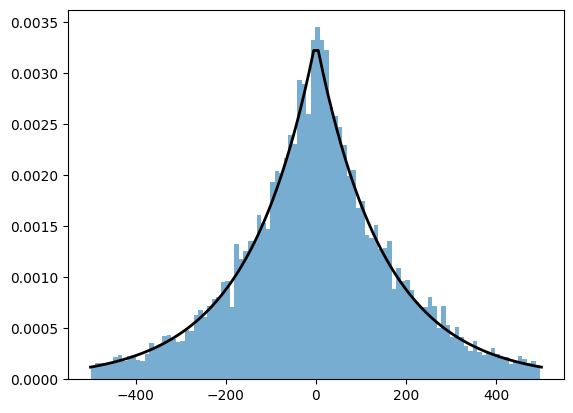

In [21]:
def laplace_rej(b, n_samples=1000, M=10.0):
    samples = []
    while len(samples) < n_samples:
        z = torch.rand(n_samples) * M                 # proposal
        u = torch.rand(n_samples)                     # uniform for accept
        accepted = z[u <= torch.exp(-z / b)]          # accept step
        # add random signs
        signs = (torch.randint(0, 2, accepted.shape).float() * 2 - 1)
        samples.extend((signs * accepted).tolist())
    return torch.tensor(samples[:n_samples])

b = 150
M = 500

laplace_samples = laplace_rej(b, 10_000, M)

plt.hist(laplace_samples.numpy(), bins=100, density=True, alpha=0.6)

x = torch.linspace(-M, M, 100).reshape(100, 1)
plt.plot(x.numpy(), Laplace(0., b).log_prob(x).exp().detach().numpy(), 'k', linewidth=2)

In [76]:
noise_program = '''
    w1 = uniform([0, {}], 5);
    u1 = uniform([0, 1], 2);
    expw1 = 0 - w1;
    expw1 = _par*expw1;
    expw1 = exp(expw1);
    observe(u1 - expw1 <= 0);

    w2 = uniform([0, {}], 5);
    u2 = uniform([0, 1], 2);
    expw2 = 0 - w2;
    expw2 = _par*expw2;
    expw2 = exp(expw2);
    observe(u2 - expw2 <= 0);

    r = w1 - w2;
    '''

program = '''array[10] dataset;

for i in range(10){{
    dataset[i] = gauss(40, 20);
}} end for;

v = {};

avg = 0.0;
for i in range(10){{
    avg = avg + 0.1*dataset[i];
}} end for;

avg = avg + v;
'''


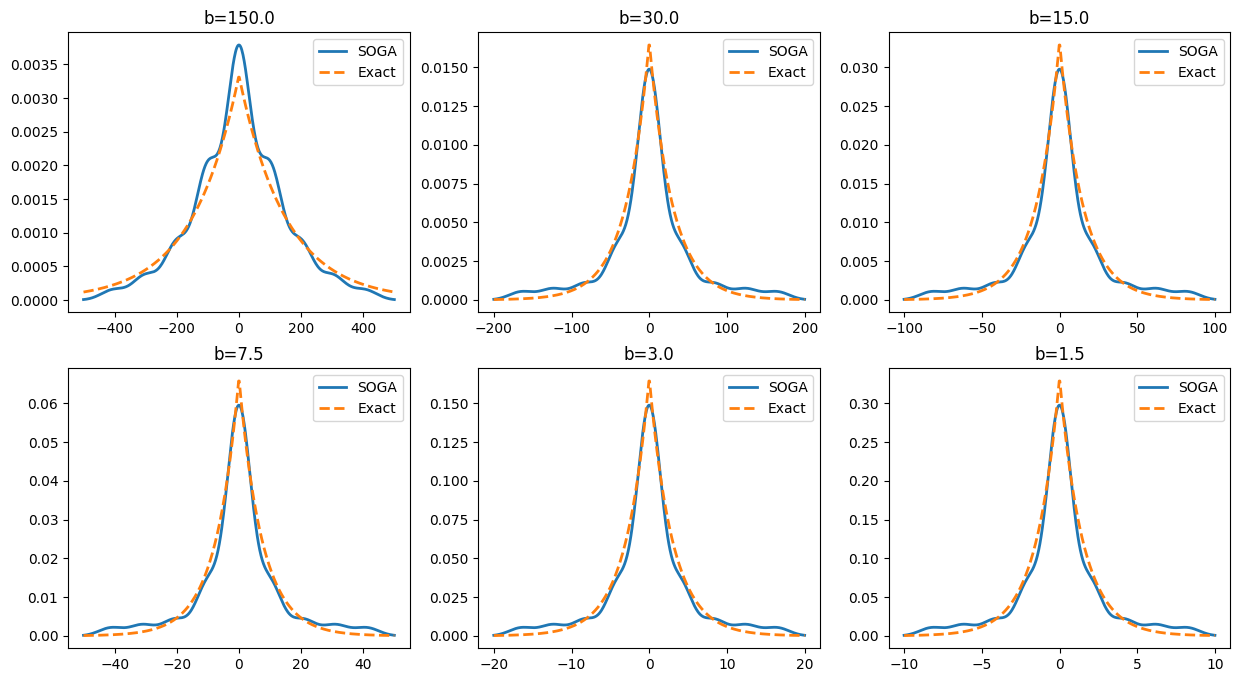

In [78]:
# the problem is that when computing the exponential of r.v. with high variance the values overflow

M_list = [500, 200, 100, 50, 20, 10]
b_list = [150., 30., 15., 7.5, 3., 1.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(len(M_list)):

    current_noise = noise_program.format(M_list[i], M_list[i])

    par = 1/b_list[i]

    compiledFile=compile2SOGA_text(current_noise)
    cfg = produce_cfg_text(compiledFile)
    params_dict = {'par': torch.tensor(par, requires_grad=False)}
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    noise_dist = extract_marginal(output_dist, ['r'])
    #pruned_noise = ranking_prune(noise_dist, 10)


    x = torch.linspace(-M_list[i], M_list[i], 500).reshape(500, 1)
    y_soga = noise_dist.gm.pdf(x).detach().numpy()

    ax = axes.flat[i]
    ax.plot(x.numpy(), y_soga, linewidth=2, label='SOGA')
    ax.plot(x.numpy(), Laplace(0., 1/par).log_prob(x).exp().detach().numpy(), '--', linewidth=2, label='Exact')
    ax.set_title(f"b={b_list[i]}")
    ax.legend()

    #print(b_list[i], noise_dist.gm.mean(), torch.sqrt(noise_dist.gm.cov()))

In [81]:
Delta = 150./10.
eps_list = torch.tensor([1., 2., 5., 10.])
M_list = [500, 200, 100, 50, 20, 10]

gvd_lap_loop_lb = {}
gvd_lap_loop_ub = {}
gvg_lap_loop_lb = {}
gvg_lap_loop_ub = {}

gvd_lap_loop = {}
gvg_lap_loop = {}

cond_entropy_lap_loop_lb = {}
cond_entropy_lap_loop_ub = {}
cond_entropy_lap_loop = {}

mi_lap_loop_lb = {}
mi_lap_loop_ub = {}
mi_lap_loop = {}

kl_lap_loop_lb = {}
kl_lap_loop_ub = {}
kl_lap_loop = {}

sampling_time = 0.
bounds_time = 0.

for i in range(len(eps_list)):

    n_samples = 100_000

    eps = eps_list[i]
    print('Eps: ', eps)

    # scale in the current iteration
    b = Delta/eps
    print('b:', b)

    # Approximating the Laplace
    current_noise = noise_program.format(M_list[i], M_list[i])
    compiledFile=compile2SOGA_text(current_noise)
    cfg = produce_cfg_text(compiledFile)
    params_dict = {'par': torch.tensor(1/b.detach().numpy(), requires_grad=False)}
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    noise_dist = extract_marginal(output_dist, ['r'])
    noise_dist = aggregate_mixture(noise_dist)
    gm_str = from_gm_to_string(noise_dist.gm)

    # adds the noise distribution to the program without observations
    formatted_program = program.format(gm_str)
    compiledFile=compile2SOGA_text(formatted_program)
    cfg = produce_cfg_text(compiledFile)

    # creates a second program with observations
    program_obs = formatted_program + '\n observe(avg == 38);'
    compiledFile=compile2SOGA_text(program_obs)
    cfg_obs = produce_cfg_text(compiledFile)

    #  Extracting marginals without obs
    output_dist = start_SOGA(cfg)
    marg_lap = extract_marginal(output_dist, ['dataset[0]', 'avg'])
    marg_lap = aggregate_mixture(marg_lap)
    s_marg = extract_marginal(output_dist, ['dataset[0]'])
    s_marg = aggregate_mixture(s_marg)
    
    # Extracting marginals with obs
    output_dist_obs = start_SOGA(cfg_obs)
    s_marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    s_marg_obs = aggregate_mixture(s_marg_obs)

    # Computes bounds
    start = time()
    gvd_lap_loop_lb['{}'.format(eps)] = vdelta_lower_bound(marg_lap, idx_o=1)
    gvd_lap_loop_ub['{}'.format(eps)] = vdelta_upper_bound(marg_lap, idx_o=1)
    gvg_lap_loop_lb['{}'.format(eps)] = vgauss_lower_bound(marg_lap, 1., idx_o=1)
    gvg_lap_loop_ub['{}'.format(eps)] = vgauss_upper_bound(marg_lap, 1., idx_o=1)

    cond_entropy_lap_loop_lb['{}'.format(eps)] = cond_entropy_lb(marg_lap, idx_o=[1])
    cond_entropy_lap_loop_ub['{}'.format(eps)] = cond_entropy_ub(marg_lap, idx_o=[1])
    
    mi_lap_loop_lb['{}'.format(eps)] = mi_lb(marg_lap, idx_o=[1])
    mi_lap_loop_ub['{}'.format(eps)] = mi_ub(marg_lap, idx_o=[1])

    kl_lap_loop_lb['{}'.format(eps)] = kl_div_lb(s_marg_obs, s_marg)
    kl_lap_loop_ub['{}'.format(eps)] = kl_div_ub(s_marg_obs, s_marg)
    end = time()
    bounds_time += end - start

    # Computes exact values via MCMC
    start = time()
    gvd_lap_loop['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='delta', secret_var='dataset[0]', output_var='avg')
    gvg_lap_loop['{}'.format(eps)] = sample_gvuln(output_dist, n_samples, gain_type='gauss', secret_var='dataset[0]', output_var='avg')
    
    cond_entropy_lap_loop['{}'.format(eps)] = sample_cond_entropy(marg_lap, idx_o=[1], n_samples=n_samples)
    
    mi_lap_loop['{}'.format(eps)] = sample_mi(marg_lap, idx_o=[1], n_samples=n_samples)
    
    kl_lap_loop['{}'.format(eps)] = sample_kl(s_marg_obs, s_marg, n_samples)
    end = time()
    sampling_time += end - start

print('Bounds time: ', bounds_time)
print('Sampling time: ', sampling_time)


Eps:  tensor(1.)
b: tensor(15.)
Eps:  tensor(2.)
b: tensor(7.5000)
Eps:  tensor(2.)
b: tensor(7.5000)
Eps:  tensor(5.)
b: tensor(3.)
Eps:  tensor(5.)
b: tensor(3.)
Eps:  tensor(10.)
b: tensor(1.5000)
Eps:  tensor(10.)
b: tensor(1.5000)
Bounds time:  14.07842206954956
Sampling time:  1232.8000316619873
Bounds time:  14.07842206954956
Sampling time:  1232.8000316619873


In [82]:
print('G-Vulnerability (Delta Gain)')
for key in gvd_lap_loop_lb.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvd_lap_loop_lb[key], gvd_lap_loop[key], gvg_lap_loop_ub[key]))

print('\n G-Vulnerability (Gauss Gain)')
for key in gvg_lap_loop_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), gvg_lap_loop_lb[key], gvg_lap_loop[key], gvg_lap_loop_ub[key]))

print('\n Conditional Entropy   ')
for key in cond_entropy_lap_loop_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), cond_entropy_lap_loop_lb[key], cond_entropy_lap_loop[key], cond_entropy_lap_loop_ub[key]))

print('\n Mutual Information   ')
for key in mi_lap_loop_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), mi_lap_loop_lb[key], mi_lap_loop[key], mi_lap_loop_ub[key]))

print('\n KL Divergence   ')
for key in kl_lap_loop_ub.keys():
    print('\t Eps = {:.1f}, lb = {:.6f}, exact={:.6f}, ub= {:.6f}'.format(float(key), kl_lap_loop_lb[key], kl_lap_loop[key], kl_lap_loop_ub[key]))

G-Vulnerability (Delta Gain)
	 Eps = 1.0, lb = 0.004688, exact=0.019947, ub= 0.049938
	 Eps = 2.0, lb = 0.005994, exact=0.019948, ub= 0.049939
	 Eps = 5.0, lb = 0.004691, exact=0.019955, ub= 0.049962
	 Eps = 10.0, lb = 0.004721, exact=0.019988, ub= 0.050285

 G-Vulnerability (Gauss Gain)
	 Eps = 1.0, lb = 0.011737, exact=0.049938, ub= 0.049938
	 Eps = 2.0, lb = 0.015006, exact=0.049939, ub= 0.049939
	 Eps = 5.0, lb = 0.011743, exact=0.049957, ub= 0.049962
	 Eps = 10.0, lb = 0.011819, exact=0.050038, ub= 0.050285

 Conditional Entropy   
	 Eps = 1.0, lb = 1.629318, exact=4.416542, ub= 7.046597
	 Eps = 2.0, lb = 1.631653, exact=4.416629, ub= 7.044195
	 Eps = 5.0, lb = 1.721634, exact=4.404684, ub= 6.953372
	 Eps = 10.0, lb = 1.900147, exact=4.406944, ub= 6.764782

 Mutual Information   
	 Eps = 1.0, lb = 0.000000, exact=-0.000663, ub= 2.785353
	 Eps = 2.0, lb = 0.000000, exact=-0.001355, ub= 2.783018
	 Eps = 5.0, lb = 0.000000, exact=-0.000959, ub= 2.693037
	 Eps = 10.0, lb = 0.000000, e

## Geometric Mechanism

In [9]:
# No Noise

compiledFile=compile2SOGA('DP_Geometric.soga')
cfg = produce_cfg(compiledFile)
dist = start_SOGA(cfg)

secret_var = 'dataset[0]'
output_var = 'count' 

discrete_V1(dist, secret_var, output_var)

tensor(0.6230)

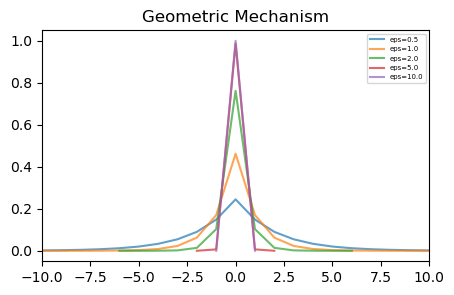

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))

eps_list = [0.5, 1., 2., 5., 10.]

for eps in eps_list:

    Delta = torch.tensor(1.)
    p = 1-torch.exp(-eps/Delta)

    str_gm = create_gm_from_p(p)

    program = 'geom1 = {}; \n geom2 = {}; \n geom = geom1 - geom2;'.format(str_gm, str_gm)

    compiledFile=compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    dist = start_SOGA(cfg)

    marg = extract_marginal(dist, ['geom'])

    x = torch.unique(marg.gm.mu[:, 0])
    y = torch.zeros_like(x)
    for i in range(len(x)):
        mask = (marg.gm.mu[:, 0] == x[i])
        y[i] = torch.sum(marg.gm.pi[mask])

    # Plot the PMF
    plt.plot(x, y, alpha=0.7, label='eps={}'.format(eps))

plt.title(f'Geometric Mechanism')
plt.xlim(-10,10)
plt.legend(fontsize=5)
plt.show()



In [11]:
eps_list = torch.tensor([0.5, 1., 2., 5., 10.])

gv_geom = {}
entropy_geom = {}
cond_entropy_geom = {}
mi_geom = {}
kl_geom = {}


for eps in eps_list:

    print('Eps: ', eps)

    # Approximating the geometric in the program
    Delta = torch.tensor(1.)
    p = 1 - torch.exp(-eps/Delta)
    gm_str = create_gm_from_p(p)

    print('p:', p)

    program = '''array[10] dataset;

                for i in range(10){{
                    dataset[i] = gm([0.5,0.5], [0., 1.], [0.0, 0.0]);
                }} end for;
                count = 0.0;

                for i in range(10){{
                    count = count + dataset[i];
                }} end for;

                geom1 = {};
                geom2 = {}; 
                noise = geom1 - geom2;

                count = count + noise;
                '''.format(gm_str, gm_str)

    # computing SOGA outputs
    compiledFile = compile2SOGA_text(program)
    cfg = produce_cfg_text(compiledFile)
    output_dist = start_SOGA(cfg)
    #output_dist = aggregate_mixture(output_dist)

    program_obs = program + '\n observe(count == 2.);'
    compiledFile = compile2SOGA_text(program_obs)
    cfg = produce_cfg_text(compiledFile)
    output_dist_obs = start_SOGA(cfg)
    #output_dist_obs = aggregate_mixture(output_dist_obs)

    marg = extract_marginal(output_dist, ['dataset[0]'])
    marg = aggregate_mixture(marg)
    marg_obs = extract_marginal(output_dist_obs, ['dataset[0]'])
    marg_obs = aggregate_mixture(marg_obs)

    # Computing metrics
    gv_geom['{}'.format(eps)] = discrete_V1(output_dist, secret_var, output_var)    
    cond_entropy_geom['{}'.format(eps)] = discrete_cond_entropy(output_dist, secret_var, output_var)
    mi_geom['{}'.format(eps)] = discrete_mi(output_dist, secret_var, output_var)
    kl_geom['{}'.format(eps)] = discrete_kl(marg_obs, marg, secret_var)


Eps:  tensor(0.5000)
p: tensor(0.3935)
Eps:  tensor(1.)
p: tensor(0.6321)
Eps:  tensor(2.)
p: tensor(0.8647)
Eps:  tensor(5.)
p: tensor(0.9933)
Eps:  tensor(10.)
p: tensor(1.0000)


In [15]:
print('G-Vulnerability  ')
for key in gv_geom.keys():
    print('\t Eps = {:.1f},exact={:.6f}'.format(float(key), gv_geom[key]))


print('\n Conditional Entropy   ')
for key in cond_entropy_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), cond_entropy_geom[key]))

print('\n Mutual Information   ')
for key in mi_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), mi_geom[key]))

print('\n KL Divergence   ')
for key in kl_geom.keys():
    print('\t Eps = {:.1f}, exact = {:.6f}'.format(float(key), kl_geom[key]))



G-Vulnerability  
	 Eps = 0.5,exact=0.573904
	 Eps = 1.0,exact=0.600151
	 Eps = 2.0,exact=0.616569
	 Eps = 5.0,exact=0.622768
	 Eps = 10.0,exact=0.623045

 Conditional Entropy   
	 Eps = 0.5, exact = 0.678622
	 Eps = 1.0, exact = 0.662551
	 Eps = 2.0, exact = 0.647439
	 Eps = 5.0, exact = 0.640474
	 Eps = 10.0, exact = 0.640124

 Mutual Information   
	 Eps = 0.5, exact = 0.014525
	 Eps = 1.0, exact = 0.030596
	 Eps = 2.0, exact = 0.045709
	 Eps = 5.0, exact = 0.052674
	 Eps = 10.0, exact = 0.053024

 KL Divergence   
	 Eps = 0.5, exact = 0.024309
	 Eps = 1.0, exact = 0.072741
	 Eps = 2.0, exact = 0.145760
	 Eps = 5.0, exact = 0.190451
	 Eps = 10.0, exact = 0.192728
